<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# **Procesamiento de Lenguaje Natural**
# **Desafío 5: Análisis de sentimiento con BERT**

> **Carrera de Especialización en Inteligencia Artificial, Facultad de Ingeniería**
>
> **Universidad de Buenos Aires, Agosto de 2024**
>
> Edgar David Guarin Castro (davidg@marketpsychdata.com)

En el presente trabajo se lleva a cabo el entrenamiento de un modelo de clasificación de análisis de sentimiento para un dataset de recomendaciones de apps utilizando BERT como encoder.

## **0. Importando librerías**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from transformers import TFBertModel
from transformers import InputExample, InputFeatures
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

## **1. Definiendo el modelo**

Inicialmente, se carga un modelo BERT preentrenado. Luego, se imprime un resumen de la arquitectura del modelo, con el fin de verificar las capas y parámetros antes de entrenarlo:


In [2]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Usando el modelo BERT cargado anteriormente, se construye ahora un modelo de clasificación de sentimientos utilizando BERT como extractor de características y agregando capas densas para hacer la clasificación con base en esas características.

En este caso, se encontró una incompatibilidad de tipos entre las entradas de Keras y lo que espera el modelo BERT en la implementación de transformers, por lo que fue necesario envolver la llamada al modelo BERT dentro de una capa personalizada (`tensorflow.keras.layers.Lambda`) para garantizar que las entradas se procesen correctamente.

In [3]:
#-----------------
# Longitud máxima de las secuencias de entrada en tokens
#-----------------
max_length = 140

#-----------------
# Número de clases en el problema de clasificación
#-----------------
output_shape = 3

#-----------------
# Congelando las capas de BERT para no actualizar sus pesos en el entrenamiento
#-----------------
bert_model.bert.trainable = False

#-----------------
# Secuencia de tokens que representan las palabras del texto
#-----------------
input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

#-----------------
# Mascara para indicar tokens válidos (generalmente 1) y de relleno (generalmente 0)
#-----------------
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

#-----------------
# Usando Lambda layer para aplicar el modelo BERT
#-----------------
def apply_bert(inputs):
    input_ids, attention_mask = inputs
    return bert_model(input_ids=input_ids, attention_mask=attention_mask)[0]

#-----------------
# Pasando las entradas al modelo BERT
#-----------------
bert_output = tensorflow.keras.layers.Lambda(apply_bert, output_shape=(max_length, 768))([input_ids, attention_mask])

#-----------------
# Extrayendo la representación de la secuencia
#-----------------
pooled_output = tensorflow.keras.layers.GlobalAveragePooling1D()(bert_output)

#-----------------
# Capa de Dropout con una tasa del 20%
#-----------------
x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)

#-----------------
# Capa de salida: Dense(output_shape) indica que tendrá tantas neuronas como clases hay en el problema (3)
#-----------------
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

#-----------------
# Creando el modelo final con las entradas y salidas
#-----------------
model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#-----------------
# Compilando el modelo
#-----------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

#-----------------
# Imprimiendo un resumen del modelo
#-----------------
print(pooled_output,"\n")

model.summary()

<KerasTensor shape=(None, 768), dtype=float32, sparse=False, name=keras_tensor_1> 



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 140)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 140)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 140, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ lambda[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │          2,307 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

Para visualizar las métricas de rendimiento del modelo durante el entrenamiento, se definen las siguientes funciones. Estas funciones crean gráficos que muestran cómo cambian la precisión (accuracy) y el puntaje F1 (f1_score) a lo largo de las épocas de entrenamiento.

Las funciones toman como argumento el objeto `history` que es el resultado de entrenar un modelo en Keras (el objeto retornado por model.fit). Contiene un diccionario (history.history) con los valores de las métricas de rendimiento (como accuracy, f1_score, val_accuracy, val_f1_score, etc.).

In [4]:
#-----------------
# Función para visualizar la precisión
#-----------------
def plot_accuracy(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.xlabel('Epocas')
    plt.ylabel('Precisión')
    plt.show()

#-----------------
# Función para visualizar el puntaje F1
#-----------------
def plot_f1_score(history):
    epoch_count = range(1, len(history.history['f1_score']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['f1_score'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_f1_score'], label='valid')
    plt.xlabel('Epocas')
    plt.ylabel('F1 Score')
    plt.show()

## **2. Cargando los datos**

Se usará el dataset de críticas de Google Apps disponible en formato csv:

In [5]:
#-----------------
# Descargando la carpeta de dataset
#-----------------
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  42356      0  0:00:03  0:00:03 --:--:-- 98412
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   378k      0  0:00:18  0:00:18 --:--:-- 1871k


Del dataset se usa el archivo `reviews.csv` para cargarlo en un DataFrame de pandas, ya que este archivo contiene los datos de las reseñas de las aplicaciones, incluyendo las puntuaciones (ratings):

In [6]:
#-----------------
# Cargando el dataset de reviews
#-----------------
df = pd.read_csv('reviews.csv')
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner


Para explorar los datos se muestran los valores únicos de la columna `score` del DataFrame, que contiene las puntuaciones de las críticas. También se imprime la cantidad de críticas correspondientes al número de filas del DataFrame.

Al final se presenta un gráfico de barras que muestra la frecuencia de cada valor en la columna score. En el se observa cómo las puntuaciones en las reseñas se concentran principalmente en 3. También se observa que las reseñas de 4 y 5 son mayores que las de 1 y 2:

Tipos de puntuaciones: [1 2 3 4 5]
Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

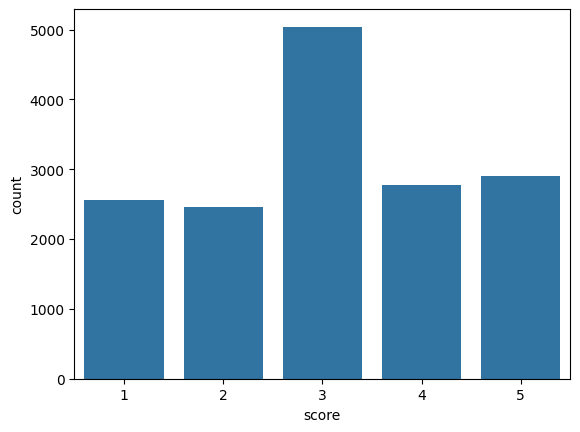

In [7]:
#-----------------
# Revisando el datasaet
#-----------------
print("Tipos de puntuaciones:", df.score.unique())
print("Cantidad de críticas:", len(df))
sns.countplot(x=df.score)

##**3. Pre-procesamiento de datos**

Debido a que el modelo será entrenado usando un sistema de 3 scores (negativo, neutro, positivo), es necesario transformar la escala de puntuaciones a una escala de sentimiento como se hace a continuación.

Después de la transformación, se revisan las etiquetas y sus distribuciones con un histograma, en el que se aprecia cómo la mayoría de reseñas son positivas como se esperaba, de acuerdo al histograma anterior.

Valores únicos de sentimiento: [0 1 2]
Nombres de las clases: ['negative', 'neutral', 'positive']


<ipython-input-8-a11a553205e5>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


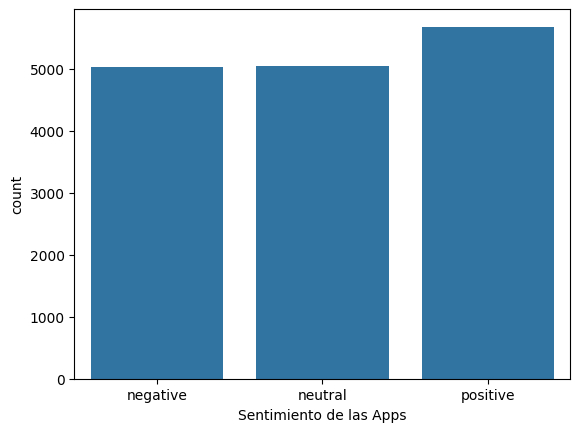

In [8]:
#-----------------
# Transformando las puntuaciones en índices de sentimiento
#-----------------
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

#-----------------
# Revisando el nuevo datasaet
#-----------------
print("Valores únicos de sentimiento:", df.sentiment.unique())
print("Nombres de las clases:", class_names)
ax = sns.countplot(x = df.sentiment)
plt.xlabel('Sentimiento de las Apps')
ax.set_xticklabels(class_names);

Las oraciones del dataset son revisada en la siguiente celda:

In [9]:
#-----------------
# Revisando las oraciones
#-----------------
sentences = df['content'].values
print("Forma del conjunto de oraciones:", sentences.shape)
sentences[:3]

Forma del conjunto de oraciones: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Para entender las características de los datos textuales antes de procesarlos, se lleva a cabo:
- una extracción de oraciones.
- el cálculo de longitudes (en caracteres) de cada reseña. Esto se almacena en una lista.
- el cálculo de la mediana de las longitudes de las reseñas para tener una idea de la longitud típica.
- una visualización de la distribución de estas longitudes para obtener una visión más clara de cómo varían las longitudes de las reseñas en el conjunto de datos.

Longitud media de las oraciones: 139.0


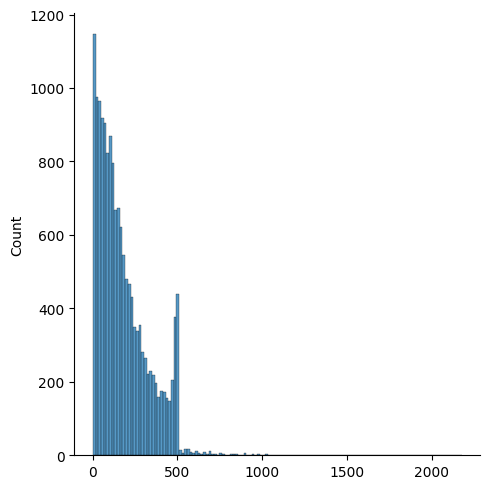

In [10]:
#-----------------
# Extrayendo la longitud de las oraciones
#-----------------
sentence_lens = []
for sentence in sentences:
  sentence_lens.append(len(sentence))

#-----------------
# Calculando la longitud media de las oraciones
#-----------------
print("Longitud media de las oraciones:", np.median(sentence_lens))

#-----------------
# Visualizando la distribución de las longitudes de las oraciones
#-----------------
sns.displot(sentence_lens)

El histograma muestra que las oraciones cortas con algunas palabras son las más comunes, siendo la longitud média de unos 139 tokens.

Ahora las etiquetas de clasificación (sentiment) se preparan para su uso en el modelo, convirtiéndolas en un formato adecuado para la clasificación multiclase y determinando la forma de la salida del modelo. De esta forma, se realiza:

- una extracción de etiquetas de sentimiento de las reseñas.
- una conversión a formato categórico (one-hot), necesario para la clasificación multiclase en redes neuronales.
- un cálculo del número de clases en el conjunto de datos, que se usará para definir la capa de salida del modelo.
- una verificación de la forma de las etiquetas y una muestra de las mismas para ver que la conversión se realizó correctamente.

In [11]:
#-----------------
# Extrayendo las etiquetas de sentimiento
#-----------------
y = df['sentiment'].values

#-----------------
# Convirtiendo las etiquetas a formato categórico
#-----------------
y = to_categorical(y)

#-----------------
# Calculando el número de clases
#-----------------
output_shape = y.shape[1]

#-----------------
# Revisando las etiquetas
#-----------------
print("Forma de y:", y.shape)
print(y[:3])
print("Forma del output:", output_shape)

Forma de y: (15746, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Forma del output: 3


## **4. Preparando los datos de entrenamiento y validación**

Los datos se separan en conjuntos de entrenamiento, validación y prueba, para usar el modelo base de BERT con su correspondiente tokenizer que es más liviano.

En el modelo `bert-base-uncased`, `uncased` significa que el modelo no distingue entre mayúsculas y minúsculas, es decir, trata "apple" y "Apple" como la misma palabra.

In [12]:
#-----------------
# Descargando el modelo base de BERT
#-----------------
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#-----------------
# Longitud máxima de las secuencias
#-----------------
max_length = 140

#-----------------
# Creando índices para separar el conjunto de datos
#-----------------
indices = np.arange(len(sentences))

#-----------------
# Separando los datos en entrenamiento y prueba
#-----------------
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

#-----------------
# Revisando los datos
#-----------------
print("Primera oración:\n", sentences[0])
print("\nEtiqueta one-hot encoder de la primera oración:",y[0])
print("\nNúmero de muestras de entrenamiento:", idx_train.shape[0], "validación:", idx_val.shape[0], "y prueba:", idx_test.shape[0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Primera oración:
 Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.

Etiqueta one-hot encoder de la primera oración: [1. 0. 0.]

Número de muestras de entrenamiento: 10076 validación: 2520 y prueba: 3150


Se definen ahora dos funciones para convertir los datos textuales en un formato adecuado para ser procesados por el modelo BERT en TensorFlow. Estas funciones ayudan a transformar los textos y sus etiquetas en ejemplos que pueden ser utilizados para entrenar y validar el modelo.

La función `convert_data_to_examples` toma el texto y las etiquetas y los convierte en una lista de objetos InputExample, que son usados por BERT para manejar las entradas de texto y las etiquetas correspondientes.

La función `convert_examples_to_tf_dataset` convierte los ejemplos de entrada (InputExample) en un formato que puede ser utilizado como un `tf.data.Dataset`, que es la estructura de datos utilizada por TensorFlow para manejar grandes cantidades de datos de manera eficiente durante el entrenamiento.

In [7]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    #-----------------
    # Lista de objetos InputExample para los datos de entrenamiento
    #-----------------
    train_InputExamples = [InputExample(guid=None,text_a = text[i],text_b = None,label = labels[i]) for i in idx_train]

    #-----------------
    # Lista de objetos InputExample para los datos de validación
    #-----------------
    validation_InputExamples = [InputExample(guid=None,text_a = text[i],text_b = None,label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    #-----------------
    # Lista para almacenar los features (tokens y máscaras de atención)
    #-----------------
    features = []

    for e in examples:
        #-----------------
        # Tokenización del texto
        #-----------------
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # paddea a la derecha por default
            truncation=True
        )

        #-----------------
        # Extracción de tokens y máscaras de atención
        #-----------------
        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        #-----------------
        # Creando los features
        #-----------------
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    #-----------------
    # Función generadora para no levantar todos los datos en un instante
    #-----------------
    def gen():
        for f in features:
            #-----------------
            # Generando un diccionario con los tokens y máscaras de atención
            #-----------------
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    #-----------------
    # Creando el dataset de TensorFlow
    #-----------------
    return tensorflow.data.Dataset.from_generator(
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

El procesamiento final de los datos antes de entrenar el modelo consiste en convertir los datos de texto en ejemplos de entrada para BERT, crear los conjuntos de datos de TensorFlow (`tf.data.Dataset`) para entrenamiento y validación, y preparar los datos para realizar predicciones en un conjunto de prueba.

In [14]:
#-----------------
# Convirtiendo los datos de texto y etiquetas en ejemplos de entrada
#-----------------
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

#-----------------
# Revisando los datos
#-----------------
print(train_InputExamples[0], validation_InputExamples[0])

#-----------------
# Convirtiendo los ejemplos de entrada en conjuntos de datos de TensorFlow
#-----------------
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)

#-----------------
# Mezclando los datos de entrenamiento y batcheando
#-----------------
train_data = train_data.shuffle(100).batch(32)

#-----------------
# Creando el conjunto de validación
#-----------------
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)

#-----------------
# Batcheando los datos de validación
#-----------------
validation_data = validation_data.batch(32)

#-----------------
# Lista de oraciones usadas para hacer predicciones
#-----------------
pred_sentences = [sentences[i] for i in idx_test]

#-----------------
# Tokenizando las oraciones de prueba
#-----------------
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

InputExample(guid=None, text_a="Excellent overall, very flexible with many useful features. Only suggestion I'd make for improvement is a feature that as the user if they really intend to complete a task that has been snoozed multiple times.", text_b=None, label=array([0., 0., 1.])) InputExample(guid=None, text_a="Delete imformation I had typed in. Didn't understand why it kept taking me to my google calendar", text_b=None, label=array([0., 0., 1.]))


Los datos de prueba son preparados usando los identificadores de los tokens que representan las palabras de las oraciones de prueba y la máscara de atención que indica cuáles tokens en la secuencia son realmente parte del texto y cuáles son tokens de padding (relleno). Cada `input_id` corresponde así a un token en el vocabulario de BERT.


In [15]:
X_test = [tf_batch['input_ids'], tf_batch['attention_mask']]
X_test

[<tf.Tensor: shape=(3150, 140), dtype=int32, numpy=
 array([[  101,  2129,  2000, ...,     0,     0,     0],
        [  101, 10166,  1012, ...,     0,     0,     0],
        [  101,  1045,  2288, ...,     0,     0,     0],
        ...,
        [  101,  1045,  2066, ...,     0,     0,     0],
        [  101,  5587,  2129, ...,     0,     0,     0],
        [  101,  2204, 10439, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(3150, 140), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>]

Finalmente, se seleccionan las etiquetas de prueba (`y_test`) correspondientes a las oraciones de prueba (`sentences[idx_test]`) que fueron preparadas previamente, donde `y` es el array que contiene las etiquetas de las reseñas, en formato one-hot encoded. Cada etiqueta en `y` corresponde a una de las oraciones en el conjunto de datos.

In [16]:
y_test = y[idx_test]
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## **5. Entrenamiento del modelo BERT Multiclass Classification**

Se inicia el entrenamiento y se grafica la precisión y el F1 score para evaluar la calidad del entrenamiento:

Epoch 1/10
    315/Unknown 113s 303ms/step - accuracy: 0.3335 - f1_score: 0.3299 - loss: 1.1784

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 149s 417ms/step - accuracy: 0.3335 - f1_score: 0.3299 - loss: 1.1784 - val_accuracy: 0.3758 - val_f1_score: 0.2982 - val_loss: 1.1177 - learning_rate: 0.0010
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 117s 357ms/step - accuracy: 0.3481 - f1_score: 0.3438 - loss: 1.1442 - val_accuracy: 0.3583 - val_f1_score: 0.2623 - val_loss: 1.1020 - learning_rate: 0.0010
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 130s 414ms/step - accuracy: 0.3281 - f1_score: 0.3233 - loss: 1.1470 - val_accuracy: 0.3587 - val_f1_score: 0.2413 - val_loss: 1.1090 - learning_rate: 0.0010
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 124s 357ms/step - accuracy: 0.3411 - f1_score: 0.3335 - loss: 1.1338 - val_accuracy: 0.3659 - val_f1_score: 0.2914 - val_loss: 1.1007 - learning_rate: 0.0010
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 112s 354ms/step - accuracy: 0.3437 - f1_score: 0.3399 - loss: 1.1325 - val_accuracy: 0.3540 - val_f1_score: 0.2460 - val_loss: 1.1098 - learning_rate: 0.0010
Epoch 6/10
315/315 ━━

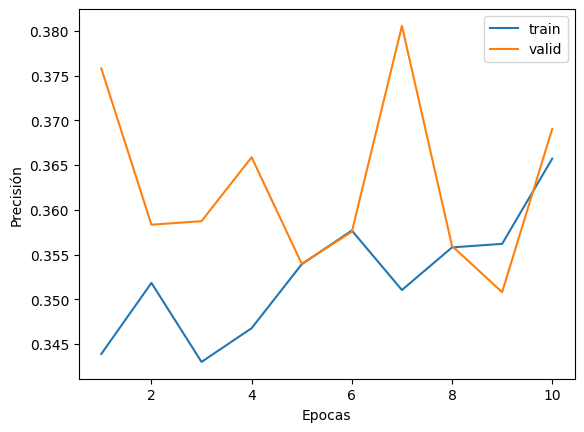

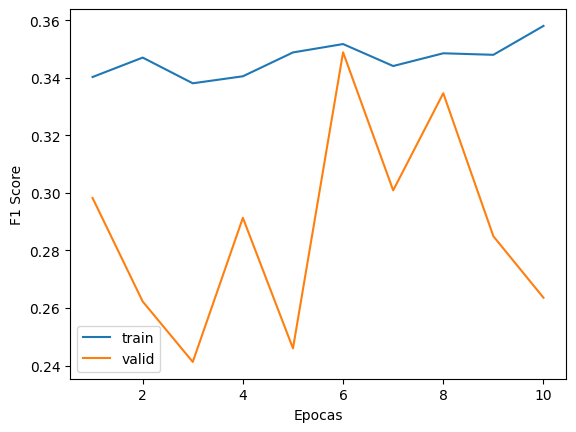

In [23]:
epochs = 10

#-----------------
# Implementando el scheduler
#-----------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitorea la pérdida de validación
                              factor=0.5,          # Factor por el cual se reduce la tasa de aprendizaje
                              patience=2,          # Número de épocas con estancamiento para reducir el learning rate
                              min_lr=0.00001)      # Límite inferior para la tasa de aprendizaje

#-----------------
# Entrenando el modelo
#-----------------
his = model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=[reduce_lr])

#-----------------
# Graficando la precisión
#-----------------
plot_accuracy(his)

#-----------------
# Graficando el F1 score
#-----------------
plot_f1_score(his)

Los gráficos muestran que, aunque durante el entrenamiento la precisión y el F1 score tienden a aumentar, sus valores son bajos. Además, tanto la precisión como el F1 score tienen comportamientos erráticos durante la validación, indicando un posible sobreajuste.

Con base en los resultados del entrenamiento, se hacen predicciones sobre el conjunto de prueba, primero obteniendo probabilidades y luego convirtiéndolas en clases predichas.

Después se evalúa el modelo en el conjunto de prueba para obtener una métrica de rendimiento, como la precisión o el F1 score.

In [24]:
#-----------------
# Realizando predicciones
#-----------------
y_hat_prob = model.predict(X_test)
print(y_hat_prob[:3])

#-----------------
# Convirtiendo las probabilidades en clases
#-----------------
y_hat = np.argmax(y_hat_prob, axis=1)
print(y_hat)

#-----------------
# Evaluando el modelo
#-----------------
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 ━━━━━━━━━━━━━━━━━━━━ 44s 383ms/step
[[0.40211114 0.31050435 0.28738457]
 [0.33019334 0.30081305 0.36899358]
 [0.30490333 0.3715484  0.32354826]]
[0 2 1 ... 0 1 2]
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.3216 - f1_score: 0.3137 - loss: 1.1088


0.3149206340312958

El F1 score final del modelo, aproximadamente 31.49%, coincide con el F1 score mostrado en la evaluación del modelo y refuerza la conclusión de que el modelo no está realizando predicciones de alta calidad en el conjunto de prueba.

## **6. Pruebas con el modelo entrenado**

El modelo se prueba ahora realizando una predicción de clasificación de sentimiento sobre un texto nuevo (en este caso, "I love this app!"):

In [25]:
text = "I love this app!"

#-----------------
# Tokenizando el texto
#-----------------
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length,
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='tf'
)

#-----------------
# Imprimiendo los identificadores de los tokens y la máscara de atención
#-----------------
print("Ids de los inputs:", tf_batch['input_ids'])
print("Máscara de atención:", tf_batch['attention_mask'])

#-----------------
# Lista de input_ids y attention_mask utilizados como entrada
#-----------------
X_ensayo = [tf_batch['input_ids'], tf_batch['attention_mask']]

#-----------------
# Predicción utilizando X_ensayo como entrada
#-----------------
y_prob_ensayo = model.predict(X_ensayo)

#-----------------
# Convirtiendo las probabilidades en clases
#-----------------
y_prob = np.argmax(y_prob_ensayo, axis=1)

#-----------------
# Imprimiendo la clase predicha
#-----------------
print("Clasificación:", class_names[int(y_prob[0])])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Ids de los inputs: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Máscara de atención: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

## **7. Ajuste fino del modelo**

En esta parte se efectúa un ajuste fino sobre el modelo BERT para mejorar su rendimiento después del entrenamiento inicial.

Para el ajuste fino se recomienda utilizar al menos un learning rate 100 veces menor que el original.

El proceso de ajuste fino consiste en:

- configurar el entorno para asegurar que TensorFlow utilice la versión heredada de Keras.
- copiar del modelo original para realizar el ajuste fino.
- configurar las capas del modelo como entrenables, lo que permite actualizar los pesos durante el ajuste fino.
- compilar el modelo con un learning rate bajo, utilizando la entropía cruzada categórica como función de pérdida y definiendo las métricas de evaluación.

In [27]:
#-----------------
# Configuración del entorno
#-----------------
os.environ['TF_USE_LEGACY_KERAS'] = '1'

#-----------------
# Copiando el modelo original
#-----------------
model2 = model

#-----------------
# Configurando las capas como entrenables
#-----------------
for layer in model2.layers:
  layer.trainable = True

#-----------------
# Compilando el modelo
#-----------------
model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

#-----------------
# Revisando el modelo
#-----------------
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 140)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 140)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 140, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ lambda_2[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │          2,307 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

A partir del ajuste fino, se entrena el nuevo modelo y se grafican la precisión y el F1 score para evaluar el desempeño del entrenamiento:

Epoch 1/10
    315/Unknown 115s 304ms/step - accuracy: 0.3620 - f1_score: 0.3156 - loss: 1.1147

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 149s 414ms/step - accuracy: 0.3620 - f1_score: 0.3156 - loss: 1.1147 - val_accuracy: 0.3556 - val_f1_score: 0.3251 - val_loss: 1.0952 - learning_rate: 1.0000e-05
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 112s 357ms/step - accuracy: 0.3597 - f1_score: 0.3490 - loss: 1.0997 - val_accuracy: 0.3663 - val_f1_score: 0.3266 - val_loss: 1.0940 - learning_rate: 1.0000e-05
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 112s 354ms/step - accuracy: 0.3624 - f1_score: 0.3519 - loss: 1.0990 - val_accuracy: 0.3671 - val_f1_score: 0.3261 - val_loss: 1.0934 - learning_rate: 1.0000e-05
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 111s 354ms/step - accuracy: 0.3617 - f1_score: 0.3522 - loss: 1.0987 - val_accuracy: 0.3651 - val_f1_score: 0.3200 - val_loss: 1.0933 - learning_rate: 1.0000e-05
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 112s 354ms/step - accuracy: 0.3664 - f1_score: 0.3543 - loss: 1.1018 - val_accuracy: 0.3667 - val_f1_score: 0.3242 - val_loss: 1.0930 - learning_rate: 1.0000e-05
E

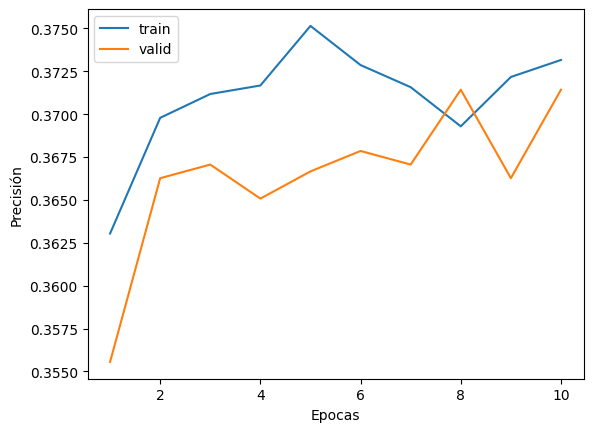

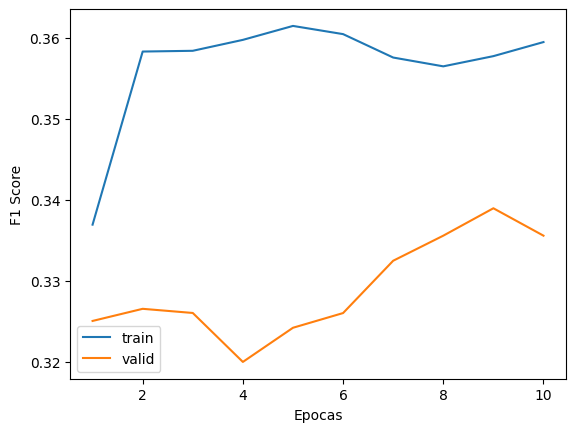

In [28]:
#-----------------
# Implementando el scheduler
#-----------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitorea la pérdida de validación
                              factor=0.5,          # Factor por el cual se reduce la tasa de aprendizaje
                              patience=2,          # Número de épocas con estancamiento para reducir el learning rate
                              min_lr=0.00001)      # Límite inferior para la tasa de aprendizaje

#-----------------
# Entrenando el modelo
#-----------------
his2 = model2.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=[reduce_lr])

#-----------------
# Graficando la precisión
#-----------------
plot_accuracy(his2)

#-----------------
# Graficando el F1 score
#-----------------
plot_f1_score(his2)

Los gráficos muestran una mejora en el proceso de entrenamiento después de implementar un ajuste fino al modelo. Los valores de precisión y F1 score son un poco mayores en relación con los valores obtenidos en el entrenamiento anterior. Además, durante la validación no se observan tantas fluctuaciones como antes.

No obstante, tanto la precisión de entrenamiento como la de validación aún muestran fluctuaciones significativas a lo largo de las épocas. Esto podría ser un signo de que el modelo no está entrenando de manera estable, lo que podría estar relacionado con un learning rate demasiado alto, una cantidad insuficiente de datos, o un modelo que es demasiado complejo para el conjunto de datos.

Con base en los resultados del entrenamiento, se hacen predicciones sobre el conjunto de prueba, primero obteniendo probabilidades y luego convirtiéndolas en clases predichas.

Después se evalúa el modelo en el conjunto de prueba para obtener una métrica de rendimiento, como la precisión o el F1 score.

In [29]:
#-----------------
# Realizando predicciones
#-----------------
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

#-----------------
# Convirtiendo las probabilidades en clases
#-----------------
y_hat2 = np.argmax(y_hat_prob2, axis=1)

#-----------------
# Evaluando el modelo
#-----------------
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - accuracy: 0.3224 - f1_score: 0.3155 - loss: 1.1090


0.31365078687667847

Nuevamente se obtiene un F1 score final de aproximadamente 31.36%, indicando que el modelo no está realizando predicciones de alta calidad en el conjunto de prueba.

## **8. Entrenamiento con las 5 clases originales**

En las siguientes celdas se entrena nuevamente el modelo BERT pero esta vez con las 5 clases originales de revisiones (escala de 1 a 5).

In [8]:
#-----------------
# Inicializando el tokenizador de BERT
#-----------------
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#-----------------
# Cargando el archivo de reviews en un dataframe nuevo
#-----------------
df2 = pd.read_csv('reviews.csv')

df2

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner


Revisando el conteo de scores:

In [9]:
df2.groupby("score")["score"].count()

,score
score,
1,2566
2,2462
3,5042
4,2776
5,2900


Para reducir el desequilibrio de clases, se identifican y eliminan aleatoriamente 2000 reseñas con puntuación 3.

Luego, se crea un nuevo DataFrame balanceado (`df_balanced`) que excluye estas reseñas.

Los rersultados se visualizan y se verifican mediante un gráfico de barras y un conteo por clase donde se aprecia que los conteos de clases son más similares.

Este proceso es crucial para asegurar que el modelo BERT se entrene en un conjunto de datos balanceado, lo que puede mejorar el rendimiento del modelo en la clasificación de reseñas en todas las clases disponibles.

,score
score,
1,2566
2,2462
3,3042
4,2776
5,2900


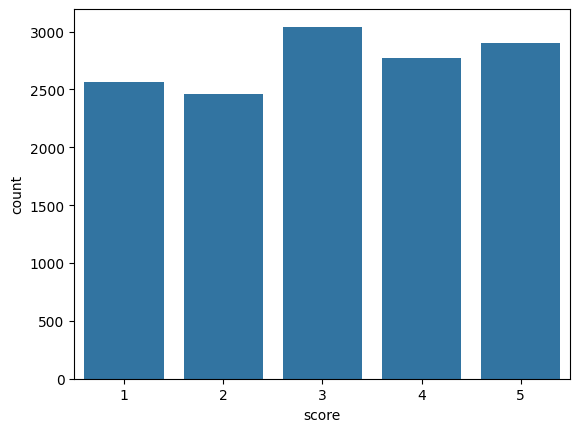

In [10]:
#-----------------
# Identificando las reseñas con puntuación 3
#-----------------
idxs_score_3 = [idx for idx, row in df2.iterrows() if row['score'] == 3]

#-----------------
# Seleccionando 2000 de ellas al azar
#-----------------
random_idxs_score_3 = random.sample(idxs_score_3,2000)

#-----------------
# Eliminando las reseñas seleccionadas
#-----------------
df_balanced = df2[~df2.index.isin(random_idxs_score_3)]

#-----------------
# Graficando un histograma de los scores
#-----------------
sns.countplot(x=df_balanced.score)

#-----------------
# Revisando el conteo de scores
#-----------------
df_balanced.groupby("score")["score"].count()

Con los datos balanceados, se verifican ahora algunas oraciones del dataframe:

In [11]:
#-----------------
# Seleccionando oraciones del dataframe
#-----------------
sentences = df_balanced['content'].values
print("Forma de sentences:", sentences.shape)
sentences[:3]

Forma de sentences: (13746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Para garantizar que las etiquetas estén en el formato correcto y que los datos se dividan adecuadamente en conjuntos de entrenamiento, validación y prueba, las puntuaciones se convierten a formato one-hot encoded para la clasificación multiclase.

Luego, se divide el conjunto de datos en conjuntos de entrenamiento, validación y prueba utilizando índices aleatorios, asegurando que cada conjunto tenga la proporción adecuada de datos.

Finalmente, se verifica una muestra de los datos (una oración y su etiqueta) para asegurar que todo esté correctamente preparado.

In [12]:
#-----------------
# Convirtiendo las puntuaciones en etiquetas one-hot encoded
#-----------------
y = df_balanced['score'].values
y = to_categorical(y)
output_shape = y.shape[1]

#-----------------
# Longitud máxima para la secuencia de tokens
#-----------------
max_length = 140

#-----------------
# Creando índices para separar los datos
#-----------------
indices = np.arange(len(sentences))

#-----------------
# Separando los datos
#-----------------
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

#-----------------
# Revisando un ejemplo
#-----------------
print("Oración: ", sentences[0])
print("\nEtiqueta:", y[0])

Oración:  Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.

Etiqueta: [0. 1. 0. 0. 0. 0.]


Los pasos finales de preprocesamiento y preparación de los datos para entrenar, validar y probar el modelo BERT consisten en:

- convertir los textos y etiquetas en ejemplos de entrada que BERT pueda procesar.
- convertir estos ejemplos en conjuntos de datos de TensorFlow para entrenamiento y validación, organizados en lotes.
- tokenizar y organizar las oraciones y etiquetas del conjunto de prueba para la evaluación del modelo.
- verificar un ejemplo de entrenamiento y uno de validación para asegurar que el preprocesamiento se ha realizado correctamente.


In [13]:
#-----------------
# Convirtiendo los datos de texto y etiquetas en ejemplos de entrada
#-----------------
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

#-----------------
# Convirtiendo los ejemplos en datos de entrenamiento para TensorFlow
#-----------------
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)

#-----------------
# Mezclando los datos de entrenamiento y batcheando
#-----------------
train_data = train_data.shuffle(100).batch(32)

#-----------------
# Convirtiendo los ejemplos en datos de validación para TensorFlow
#-----------------
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)

#-----------------
# Batcheando los datos de validación
#-----------------
validation_data = validation_data.batch(32)

#-----------------
# Lista de oraciones usadas para hacer predicciones
#-----------------
pred_sentences = [sentences[i] for i in idx_test]

#-----------------
# Tokenizando las oraciones de prueba
#-----------------
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

#-----------------
# Creando la entrada de prueba: identificadores de tokens y máscaras de atención para las oraciones
#-----------------
X_test = [tf_batch['input_ids'], tf_batch['attention_mask']]

#-----------------
# Seleccionando las etiquetas de las oraciones de prueba
#-----------------
y_test = y[idx_test]

#-----------------
# Revisando un ejemplo de entrenamiento y validación
#-----------------
print("Ejemplo de entrenamiento:", train_InputExamples[0])
print("\nEjemplo de validación:", validation_InputExamples[0])

Ejemplo de entrenamiento: InputExample(guid=None, text_a='i love this app so far but the notifications are not really working for me', text_b=None, label=array([0., 0., 0., 1., 0., 0.]))

Ejemplo de validación: InputExample(guid=None, text_a="I cannot even create an account I fill in what's needed and I'm pressing the button and it's not working some1 help.", text_b=None, label=array([0., 1., 0., 0., 0., 0.]))


De este modo, se crea un modelo de clasificación basado en BERT, usando el modelo BERT preentrenado y congelando sus capas para entrenar solo las capas adicionales.

In [14]:
#-----------------
# Cargando el modelo BERT preentrenado
#-----------------
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

#-----------------
# Congelando las capas del modelo BERT
#-----------------
bert_model.bert.trainable = False

#-----------------
# Secuencia de tokens que representan las palabras del texto
#-----------------
input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

#-----------------
# Mascara para indicar tokens válidos (generalmente 1) y de relleno (generalmente 0)
#-----------------
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

#-----------------
# Pasando las entradas al modelo BERT
#-----------------
bert_output = tensorflow.keras.layers.Lambda(apply_bert, output_shape=(max_length, 768))([input_ids, attention_mask])

#-----------------
# Extrayendo la representación de la secuencia
#-----------------
pooled_output = tensorflow.keras.layers.GlobalAveragePooling1D()(bert_output)

#-----------------
# Definiendo las capas adicionales del modelo
#-----------------
x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

#-----------------
# Creando el modelo final
#-----------------
model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#-----------------
# Compilando el modelo final
#-----------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

El modelo se entrena utilizando datos de validación para monitorear el rendimiento y al final se grafica la precisión y el F1 Score macro para analizar cómo el modelo ha aprendido a lo largo del tiempo.

Epoch 1/10
    275/Unknown 95s 274ms/step - accuracy: 0.2128 - f1_score: 0.1718 - loss: 1.7254

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


275/275 ━━━━━━━━━━━━━━━━━━━━ 127s 391ms/step - accuracy: 0.2128 - f1_score: 0.1718 - loss: 1.7253 - val_accuracy: 0.2341 - val_f1_score: 0.1542 - val_loss: 1.6412 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 114s 315ms/step - accuracy: 0.2165 - f1_score: 0.1746 - loss: 1.6844 - val_accuracy: 0.2227 - val_f1_score: 0.1365 - val_loss: 1.6808 - learning_rate: 0.0010
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.2319 - f1_score: 0.1876 - loss: 1.6588 - val_accuracy: 0.2241 - val_f1_score: 0.1198 - val_loss: 1.6419 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 86s 314ms/step - accuracy: 0.2278 - f1_score: 0.1827 - loss: 1.6443 - val_accuracy: 0.2173 - val_f1_score: 0.1316 - val_loss: 1.6250 - learning_rate: 5.0000e-04
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 142s 314ms/step - accuracy: 0.2212 - f1_score: 0.1763 - loss: 1.6381 - val_accuracy: 0.2200 - val_f1_score: 0.1206 - val_loss: 1.6344 - learning_rate: 5.0000e-04
Epoch 6/10
275

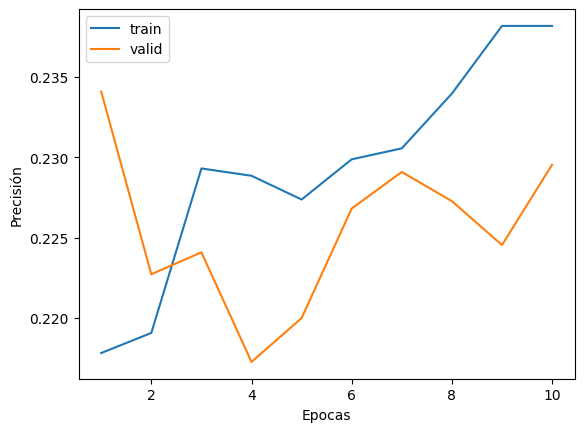

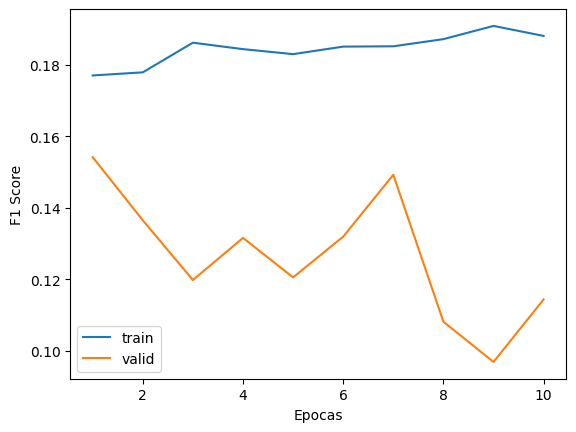

In [15]:
#-----------------
# Implementando el scheduler
#-----------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitorea la pérdida de validación
                              factor=0.5,          # Factor por el cual se reduce la tasa de aprendizaje
                              patience=2,          # Número de épocas con estancamiento para reducir el learning rate
                              min_lr=0.00001)      # Límite inferior para la tasa de aprendizaje

#-----------------
# Entrenando el modelo
#-----------------
his = model.fit(train_data, epochs=10, validation_data=validation_data, callbacks=[reduce_lr])

#-----------------
# Graficando la precisión
#-----------------
plot_accuracy(his)

#-----------------
# Graficando el F1 score
#-----------------
plot_f1_score(his)

La precisión tanto en el conjunto de entrenamiento como en el de validación es bastante baja, alrededor de 0.22 a 0.24. Esto indica que el modelo no está aprendiendo a clasificar las reseñas de manera efectiva.

También se observan fluctuaciones importantes en la precisión en ambas curvas (entrenamiento y validación) a lo largo de las épocas. Esto puede ser un indicio de inestabilidad en el entrenamiento, posiblemente debido a un tamaño de lote pequeño, o una arquitectura del modelo que no está bien adaptada al problema.

Además, la gran diferencia entre las precisiones de entrenamiento y validación en las últimas épocas, indica que el modelo podría estar sobreajustando los datos de entrenamiento y no generalizando bien.

## **9. Probando el modelo**

El modelo se prueba ahora realizando una predicción de clasificación de sentimiento sobre un texto nuevo (en este caso, "I love this app!"):

In [16]:
text = "I love this app!"

#-----------------
# Tokenizando el texto
#-----------------
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length,
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='tf'
)

#-----------------
# Lista de input_ids y attention_mask utilizados como entrada
#-----------------
X_ensayo = [tf_batch['input_ids'], tf_batch['attention_mask']]

#-----------------
# Predicción utilizando X_ensayo como entrada
#-----------------
y_prob_ensayo = model.predict(X_ensayo)

#-----------------
# Convirtiendo las probabilidades en clases
#-----------------
y_prob = np.argmax(y_prob_ensayo, axis=1)

#-----------------
# Imprimiendo la clase predicha
#-----------------
print("Clasificación:", y_prob[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Clasificación: 3


Debido al bajo rendimiento del modelo durante el entrenamiento y la validación, la predicción no es buena, ya que se esperaba una calificación mayor que 3.

El bajo rendimiento general y las fluctuaciones son señales de que el modelo necesita optimización adicional. Se podría intentar reducir la tasa de aprendizaje, agregar más regularización (como aumentar la tasa de dropout o implementar L2 regularization), o ajustar los hiperparámetros del modelo. Sin embargo, esto no fue posible implementarlo aquí debido a la falta de recursos y tiempo.


## **10. Guardando el modelo**

El modelo entrenado es guardado a continuación. Aquí, solo se guardan los pesos del modelo (los parámetros entrenables, como los pesos y sesgos de las capas), y no la estructura completa del modelo.

Guardar solo los pesos es útil para:

- Transferencia de aprendizaje: Se pueden usar los pesos entrenados para inicializar otro modelo con la misma arquitectura.
- Reentrenamiento: Se pueden cargar los pesos guardados y continuar entrenando el modelo desde ese punto.
- Implementación eficiente: Si ya se tiene la estructura del modelo codificada en un entorno de producción, solo se necesita cargar los pesos para realizar predicciones.

In [18]:
#-----------------
# Guardando el modelo
#-----------------
model.save_weights('bert.weights.h5')

El modelo previamente guardado puede ser cargado nuevamente usando la siguiente función:

In [23]:
def load_model(path):
      #-----------------
      # Cargando el tokenizador de BERT
      #-----------------
      bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

      #-----------------
      # Definiendo las entradas del modelo
      #-----------------
      input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
      attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

      #-----------------
      # Pasando las entradas al modelo BERT
      #-----------------
      bert_output = tensorflow.keras.layers.Lambda(apply_bert, output_shape=(max_length, 768))([input_ids, attention_mask])[1]

      #-----------------
      # Definiendo las capas adicionales del modelo
      #-----------------
      output = tensorflow.keras.layers.Dropout(rate=0.2)(bert_output)
      output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

      #-----------------
      # Creando el modelo final
      #-----------------
      model = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

      #-----------------
      # Cargando los pesos preentrenados
      #-----------------
      model.load_weights(path)

      return model

Así, la carga se implementa la siguiente forma:

In [26]:
#-----------------
# Cargando el modelo
#-----------------
model = load_model("bert.weights.h5")

#-----------------
# Revisando el modelo
#-----------------
print("\nPesos del modelo guardado:", model.weights[0])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


Pesos del modelo guardado: <KerasVariable shape=(768, 6), dtype=float32, path=dense_4/kernel>
